In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

In [3]:
def predict(intercept, coefficient, x):
  return intercept + coefficient * x

In [4]:
def sgd(x, y, df, epochs=100, alpha = 0.01):
    intercept, coefficient, mse = -0.5, -0.75, 0.0
    index = np.random.randint(0, len(x))
    prediction = predict(intercept, coefficient, x[index])
    mse = ((prediction - y[index]) ** 2) / 2
    df.loc[0] = [intercept, coefficient, mse]

    for i in range(1, epochs):
        # get random index
        index = np.random.randint(0, len(x))
        # get random x and y
        x_i, y_i = x[index], y[index]
        # get prediction
        prediction = predict(intercept, coefficient, x_i)
        b0_error = prediction - y_i
        b1_error = (prediction - y_i) * x_i

        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 

        mse = ((prediction - y_i) ** 2) / 2
        df.loc[i] = [intercept, coefficient, mse]
    return df

In [5]:
def adagrad(x, y, df, epochs=100, learning_rate=0.01, eps=1e-8):
    intercept, coefficient = -0.5, -0.75
    accumulated_squared_intercept_gradient = 0.0
    accumulated_squared_coefficient_gradient = 0.0

    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    mse = ((prediction - y[random_index]) ** 2) / 2
    df.loc[0] = [intercept, coefficient, mse]

    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]

        intercept_gradient = error
        coefficient_gradient = error * x[random_index]

        accumulated_squared_intercept_gradient += intercept_gradient ** 2
        accumulated_squared_coefficient_gradient += coefficient_gradient ** 2

        intercept -= (learning_rate / np.sqrt(accumulated_squared_intercept_gradient + eps)) * intercept_gradient
        coefficient -= (learning_rate / np.sqrt(accumulated_squared_coefficient_gradient + eps)) * coefficient_gradient

        mse = (error ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, mse]

    return df

In [6]:
adagrad_columns = ['intercept', 'coefficient', 'mse']
adagrad_loss_df = pd.DataFrame(columns=adagrad_columns)
adagrad_loss_df = adagrad(sepal_length, petal_width, adagrad_loss_df)

In [7]:
sgd_columns = ['intercept', 'coefficient', 'mse']
sgd_loss_df = pd.DataFrame(columns=sgd_columns)
sgd_loss_df = sgd(sepal_length, petal_width, sgd_loss_df)

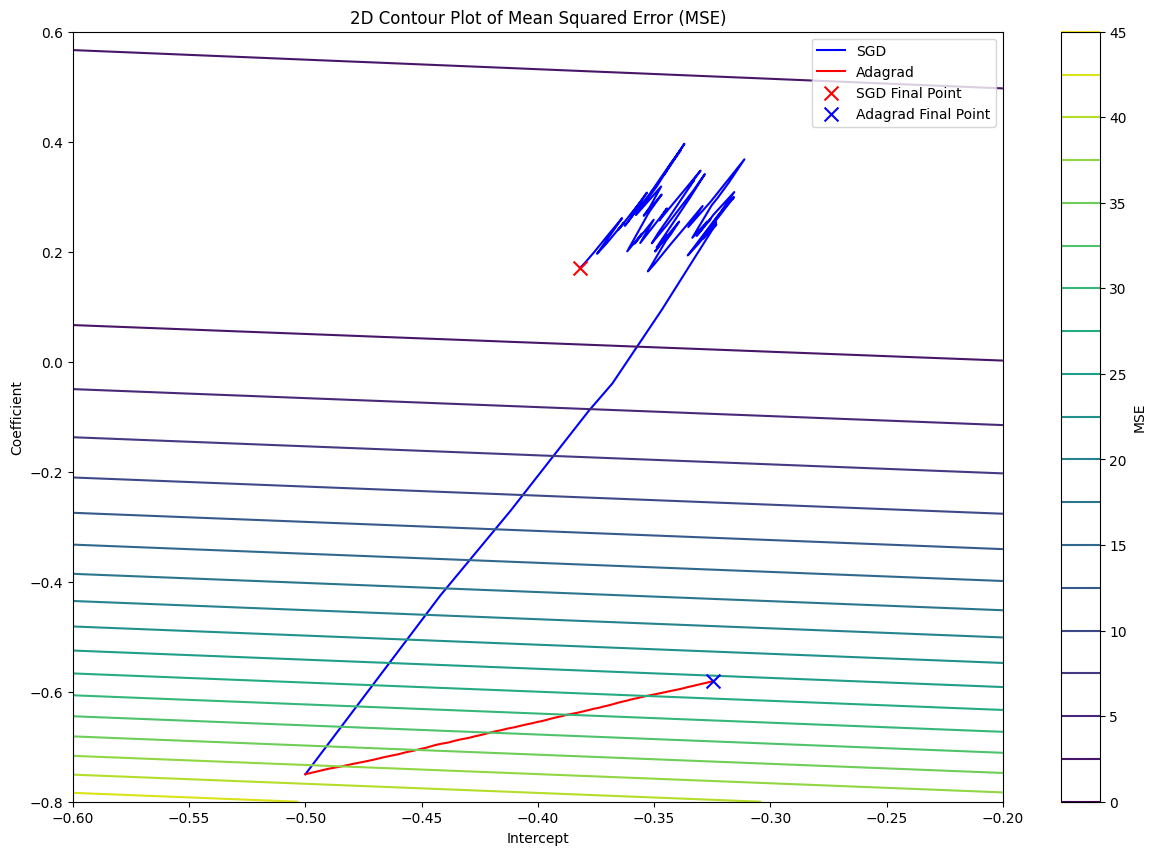

In [10]:
intercept_range = np.linspace(-0.6, -0.2, 150)
coefficient_range = np.linspace(-0.8, 0.6, 150)
intercept_grid, coefficient_grid = np.meshgrid(intercept_range, coefficient_range)

mse_grid = np.zeros_like(intercept_grid)

for i in range(len(intercept_range)):
    for j in range(len(coefficient_range)):
        # Get current intercept and coefficient values
        intercept = intercept_grid[i, j]
        coefficient = coefficient_grid[i, j]
        
        # Calculate predicted values using the current intercept and coefficient
        y_pred = intercept + coefficient * sepal_length.squeeze()
        
        # Calculate MSE (Mean Squared Error)
        mse = np.mean((y_pred - petal_width)**2)
        
        # Store MSE in the corresponding grid position
        mse_grid[i, j] = mse

plt.figure(figsize=(15, 10))
contour = plt.contour(intercept_grid, coefficient_grid, mse_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='MSE')
plt.plot(sgd_loss_df['intercept'], sgd_loss_df['coefficient'], color='b', zorder=1)
plt.plot(adagrad_loss_df['intercept'], adagrad_loss_df['coefficient'], color='r', zorder=1)
plt.scatter(sgd_loss_df.loc[len(sgd_loss_df)-1, 'intercept'], sgd_loss_df.loc[len(sgd_loss_df)-1, 'coefficient'], color='red', marker='x', s=100, zorder=2)
plt.scatter(adagrad_loss_df.loc[len(adagrad_loss_df)-1, 'intercept'], adagrad_loss_df.loc[len(adagrad_loss_df)-1, 'coefficient'], color='blue', marker='x', s=100, zorder=2)
plt.xlabel('Intercept')
plt.ylabel('Coefficient')
plt.title('2D Contour Plot of Mean Squared Error (MSE)')
plt.legend(['SGD', 'Adagrad', 'SGD Final Point', 'Adagrad Final Point'])
plt.show()